# How to use Google calendar API?

How to import Google API?



In [ ]:
var execSync = require('child_process').execSync;
try {
    require.resolve('googleapis');
    require.resolve('google-auth-library');
} catch (e) {
    execSync('npm install googleapis google-auth-library');
}
var google = require('googleapis');
var googleAuth = require('google-auth-library');

var importer = require('../Core');
var seleniumPath = __dirname + '/../Selenium/google authorize.ipynb';

// Authorize a client with the loaded credentials, then call the
  // Google Calendar API.
var oauth2Client;
var getOauthClient = (options = {}) => {
    return importer.importNotebook(seleniumPath)
    .then(r => r.authorize(options.scopes
                           || ['https://www.googleapis.com/auth/calendar']))
    .then(c => {
        var auth = new googleAuth();
        oauth2Client = new auth.OAuth2(
            c.clientId_, c.clientSecret_, c.redirectUri_);
        oauth2Client.credentials = c.credentials;
        return oauth2Client;
    })
    .then(auth => (options.auth = auth))
};
module.exports = getOauthClient;
getOauthClient;



How to list events?

In [ ]:
var google = require('googleapis');
var calendar = google.calendar('v3');
var importer = require('../Core');

var processResult = (err, response, options) => {
    if (err) {
      console.log('The API returned an error: ' + err);
      throw err;
    }
    resultEvents = []; // reset the array
    var events = response.items;
    if (events.length == 0) {
        console.log('No events found for ' + JSON.stringify(options));
    } else {
        for (var i = 0; i < events.length; i++) {
            var event = events[i];
            var start = event.start.dateTime || event.start.date;
            resultEvents[resultEvents.length] = {
                start: new Date(start), event: event};
        }
    }
    return resultEvents;
};


/**
 * Lists the next 10 events on the user's primary calendar.
 *
 * @param {google.auth.OAuth2} auth An authorized OAuth2 client.
 */
var resultEvents = [];
var getOauthClient, correctTimeLimits, correctCalendarId;
var listEvents = (options = {calendarId: 'primary'}) => {
    return importer.interpretAll([
        'import google api',
        'correct dates time',
        'lookup calendar name'
    ])
    .then(r => {
        getOauthClient = r[0].runInNewContext();
        correctTimeLimits = r[1].runInNewContext();
        correctCalendarId = r[2].runInNewContext();
        if(typeof options.auth === 'undefined') {
            return getOauthClient(options);
        }
    })
    .then(() => correctTimeLimits(options))
    .then(() => correctCalendarId(options))
    .then(() => {
        if(typeof options['calendarId'] == 'undefined') {
            options['calendarId'] = 'primary';
        }
        var data = Object.assign({}, options, {
            maxResults: 100,
            singleEvents: true,
            orderBy: 'startTime'
        });
        return new Promise((resolve, reject) => {
            calendar.events.list(data, (err, response) => {
                if(err) reject(err);
                try {
                    var events = processResult(err, response, options);
                    resolve(events);
                } catch (e) {
                    reject(e);
                }
            });
        });
    });
};
module.exports = listEvents;
listEvents;



Run todays calendar events?



In [ ]:
var google = require('googleapis');
var calendar = google.calendar('v3');
var importer = require('../Core');

var getOauthClient, listEvents, correctCalendarId;
// test Google calendar API?
var runTodaysEvents = () => {
    var options = {}, commands = [];
    var eventId, isError, commandResult;
    return importer.interpretAll([
        'list events',
        'import google calendar api',
        'lookup calendar name'
    ])
    .then(r => {
        listEvents = r[0].runInNewContext();
        getOauthClient = r[1].runInNewContext();
        correctCalendarId = r[2].runInNewContext();
        return getOauthClient(options);
    })
    .then(() => correctCalendarId(Object.assign(options, {
        calendarId: 'commands'
    })))
    .then(() => listEvents({
        auth: options.auth,
        calendarId: options.calendarId,
        timeMin: 'yesterday',
        timeMax: 'tomorrow',
    }))
    .then(events => {
        var names = events.map(e => e.event.summary);
        // filter processed
        commands = events
        .filter(e => e.event.summary.indexOf('Result:') == -1
                && names.indexOf('Result: ' + e.event.summary) == -1)
        
        // TODO: change this slice
        .slice(0, 1);
        if(commands.length == 0) throw new Error('No events!');
    })
    // process the command, this should return a function to be called after event
    .then(() => importer.interpretAll(commands[0].event.summary))
    // create a new events to store the results
    .then(r => {
        commandResult = r.runInNewContext();
        return new Promise((resolve, reject) => {
            isError = false;
            calendar.events.insert(Object.assign({}, {
                calendarId: options.calendarId,
                auth: options.auth,
                resource: {
                    start: commands[0].event.start,
                    end: commands[0].event.end,
                    summary: 'Result: ' + commands[0].event.summary,
                    description: 'starting ' + r.filename + ' - ' + commandResult,
                    colorId: 9
                }
            }), (err, response) => {
                if(err) reject(err);
                try {
                    resolve(response);
                } catch (e) {
                    reject(e);
                }
            });
        })
    })
    // store the event in memory for updating by id later
    .then(event => (eventId = event.id))
    // TODO: add parameter input from event content
    // TODO: check for retry count from event content
    // TODO: add time limits for successful commands
    .then(r => commandResult())
    .catch(e => {
        isError = true;
        return Object.getOwnPropertyNames(e).reduce((alt, key) => {
            alt[key] = e[key];
            return alt;
        }, {})
    })
    // update the calendar event with the results
    .then(r => new Promise((resolve, reject) => {
        if(typeof eventId == 'undefined') {
            return resolve(r);
        }
        calendar.events.patch({
            eventId: eventId,
            calendarId: options.calendarId,
            auth: options.auth,
            resource: {
                description: JSON.stringify(r, null, 4),
                colorId: isError ? 11 : 10
            }
        }, (err, response) => {
            if(err) reject(err);
            try {
                resolve(response);
            } catch (e) {
                reject(e);
            }
        });
    }))
};
module.exports = runTodaysEvents;
runTodaysEvents;

// echo "require('/Users/briancullinan/jupytangular2/Core').interpretAll('run todays calendar events').then(r=>r.runInNewContext()()).then(e=>{ console.log(e); process.exit(e); }).catch(e=>{console.log(e); process.exit(e) });" | node

// echo "require('/Users/briancullinan/jupytangular2/Core').interpretAll('scrape facebook events').then(r=>r.runInNewContext()()).then(e=>{console.log(e); process.exit(e) }).catch(e=>{console.log(e); process.exit(e) });" | node


test calendar api graph Iga's cycle for as long as there are valid dates



In [ ]:
var importer = require('../Core');

$$.async();
var filterDistant, getOauthClient, listEvents, graphDates;
importer.interpretAll([
    'import google calendar api',
    'how to list events',
    'number of days between events',
    'display recurrence line graph'
])
.then(r => {
    getOauthClient = r[0].runInNewContext();
    listEvents = r[1].runInNewContext();
    filterDistant = r[2].runInNewContext();
    graphDates = r[3].runInNewContext();
})
.then(() => listEvents({
    q: 'period',
    calendarId: 'p4685f6at8ccctenocjlqgnqss@group.calendar.google.com'
}))
.then(r => {
    $$.svg(graphDates(filterDistant(r)))
})
.catch(e => $$.sendError(e));




test calendar sum all hours worked on study sauce since september 2016



In [ ]:
var importer = require('../Core');

$$.async();
var sumEvents, getOauthClient, listEvents, ISODateString;
importer.interpretAll([
    'import google calendar api',
    'how to list events',
    'sum a list of events',
    'convert date to ISO'
])
.then(r => {
    getOauthClient = r[0].runInNewContext();
    listEvents = r[1].runInNewContext({getOauthClient});
    sumEvents = r[2].runInNewContext();
    ISODateString = r[3].runInNewContext();
})
.then(() => listEvents({
    timeMin: ISODateString(new Date('2016/09/22')),
    timeMax: ISODateString(new Date('2017/09/22')),
    q: 'study sauce'
}))
.then(r => {
    console.log(r);
    $$.sendResult(sumEvents(r))
})
.catch(e => $$.sendError(e));



Correct calendar dates for timeMax and timeMin?


In [ ]:
var importer = require('../Core');
var chrono = require('chrono-node');

var ISODateString;
var correctTimeLimits = (options) => {
    return importer.interpretAll([
        'convert date to ISO'
    ])
    .then(r => {
        ISODateString = r[0].runInNewContext();
        if(typeof options.timeMin !== 'undefined') {
            options.timeMin = ISODateString(
                chrono.parseDate(options.timeMin));
        }
        if(typeof options.timeMax !== 'undefined') {
            options.timeMax = ISODateString(
                chrono.parseDate(options.timeMax));
        }
        return options;
    });
};
module.exports = correctTimeLimits;
correctTimeLimits;



Lookup calendar id by name or id?



In [ ]:
var google = require('googleapis');
var calendar = google.calendar('v3');

var calendarList = [], lastCalendar;
var correctCalendarId = (options) => {
    if(typeof options.calendarId == 'undefined') {
        return Promise.resolve(Object.assign(options, {
            calendarId: 'primary'
        }))
    }
    return (calendarList.length == 0
    ? new Promise((resolve, reject) => {
        calendar.calendarList.list({
            auth: options.auth,
        }, (err, response) => {
            if(err) reject(e);
            try {
                resolve(response);
            } catch (e) {
                reject(e);
            }
        });
    })
    : Promise.resolve(calendarList))
    .then(r => {
        calendarList = r;
        var rexexp = new RegExp(options.calendarId, 'ig');
        var matches = r.items.filter(c => c.id == options.calendarId);
        if(matches.length == 0) {
            matches = r.items.filter(c => c.summary.match(rexexp));
        }
        if(lastCalendar !== matches[0].summary) {
            lastCalendar = matches[0].summary;
            console.log('Using calendar: ' + matches[0].summary
                        + ' - ' + matches[0].id);
        }
        options.calendarId = matches[0].id;
        return options;
    })
    .catch(e => console.log(e))
};
module.exports = correctCalendarId;
correctCalendarId;



In [ ]:
var importer = require('../Core');
var interpretAllPath = path.join(__dirname, '../Core/interpret all notebooks.ipynb');

var queries = 'scrape facebook events';

$$.async();
importer.importNotebook(interpretAllPath)
.then((f) => {
    interpret = f['interpret'];
    interpretObject = f['interpretObject'];
})
// use Promise.all to do all of your code searches up front
.then(r => typeof queries == 'string' 
      ? interpret(queries) 
      : Promise.all(queries.map(interpret)))
//.then(r => typeof queries == 'string' 
//      ? interpretObject([r[0]])
//      : interpretObject(r.map(r => r[0])))
.then(r => $$.sendResult(r))
.catch(e => $$.sendError(e))


Show a d3 pie chart of time spent on projects?



study sauce
[ 'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Promote Study Sauce manually?',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study sauce',
  'Create robot out of study sauce validation',
  'Work on Study sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on study sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Work on Study Sauce',
  'Wo

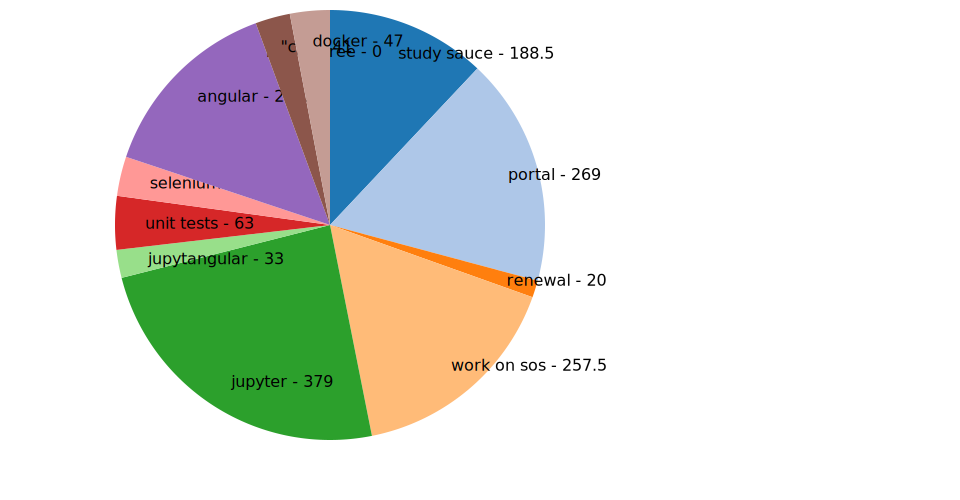

In [1]:
var importer = require('../Core');

var options = {};
var listEvents, getOauthClient, sumEvents, d3PieChart;

var calendarSearchToPieChart = (searches) => {
    return importer.interpretAll([
        'list events',
        'import google api',
        'sum a list of events',
        'd3 pie chart'
    ])
    .then(r => {
        listEvents = r[0].runInNewContext();
        getOauthClient = r[1].runInNewContext();
        sumEvents = r[2].runInNewContext();
        d3PieChart = r[3].runInNewContext();
        return getOauthClient(options);
    })
    .then(() => {
        return importer.runAllPromises(searches
        .map(s => (resolve) => listEvents({
            auth: options.auth,
            q: s
        })
        .then(r => {
            console.log(s);
            console.log(r.map(e => e.event.summary));
            resolve({label: s, value: sumEvents(r)})
        })
        .catch(e => console.log(e))))
    })
    .then(r => d3PieChart(r))
    .catch(e => console.log(e))
}

$$.async();
calendarSearchToPieChart([
    'study sauce',
    'portal',
    'renewal',
    'work on sos',
    'jupyter',
    'jupytangular',
    'unit tests',
    'selenium',
    'angular',
    'mind spree',
    '"c#"',
    'docker'
])
.then(r => $$.svg(r))
.catch(e => $$.sendError(e))



Parse bookmarks file?



In [ ]:
var importer = require('../Core');
var parseBookmarks = () => {
    var getAllXPath;
    return importer.interpretAll([
        'all xpath elements',
    ])
    .then(r => {
        getAllXPath = r[0].runInNewContext({client, XPathResult, document});
        return getAllXPath([
            '//dt[./h3]',
            {
                title: './h3/text()',
                links: [
                    './dl/dt/a',
                    {
                        url: './@href',
                        time: './@add_date',
                        title: './@text()'
                    }
                ],
                children: ['./dl/dt/h3/text()']
            }
        ])
    })
    .then(events => [].concat(...events.map(e => e.links.map(l => Object.assign(l, {folder: e.title})))))
    .then(events => {
        return events.map(e => Object.assign(e, {
            url: e.url+'',
            title: e.title+'',
            time_usec: parseFloat(e.time+'') * 1000,
        }))
        .reduce((links, event) => {
            // group by nearest half-hour and max out at 10 links
            var timeGroup = Math.round(event.time_usec / 60 / 30 / 1000) * 60 * 30 * 1000;
            if(typeof links[timeGroup] == 'undefined') {
                links[timeGroup] = [];
            }
            links[timeGroup].push(event)
            return links;
        }, {})
    });
};
module.exports = parseBookmarks;
parseBookmarks;



Update create merge delete event?



In [ ]:
var google = require('googleapis');
var calendar = google.calendar('v3');
var importer = require('../Core');

var googlePromise = (func) => {
    return new Promise((resolve, reject) => func((err, response) => {
        if(err) reject(err);
        try {
        } catch (e) {
            reject(e);
        }
        setTimeout(() => resolve(response), 100);
    })).catch(e => console.log(e));
};

var listEvents;
var updateEvent = (event) => {
    return (typeof listEvents !== 'undefined'
        ? Promise.resolve([])
        : importer.interpretAll([
            'list events',
        ])
        .then(r => {
            listEvents = r[0].runInNewContext();
        }))
    .then(() => {
        return listEvents({
            auth: options.auth,
            calendarId: options.calendarId,
            timeMin: event.start.dateTime,
            timeMax: event.end.dateTime,
        })
    })
    .then(m => {
        const actionsArray = [];
        const matches = m.filter(match => match.event.summary == event.summary)
        if(matches.length > 0) {
            const descriptions = [].concat(
                ...JSON.parse(event.description),
                ...matches.map(match => JSON.parse(match.event.description)));
            // TODO: make sure there are no duplicates
            const urls = descriptions.map(d => d.url);
            const unique = descriptions
                .filter((d, i) => urls.indexOf(d.url) === i);

            // patch the first match
            actionsArray.push(googlePromise(
                calendar.events.patch.bind(calendar.events, {
                    eventId: matches[0].event.id,
                    calendarId: options.calendarId,
                    auth: options.auth,
                    resource: {
                        description: JSON.stringify(unique, null, 4),
                    }
                })));

            // TODO: delete the rest
            for(const match of matches.slice(1)) {
                actionsArray.push(googlePromise(
                    calendar.events.delete.bind(calendar.events, {
                        eventId: match.event.id,
                        calendarId: options.calendarId,
                        auth: options.auth
                    })));
            }
        } else {
            actionsArray.push(googlePromise(
                calendar.events.insert.bind(calendar.events, Object.assign({}, {
                    calendarId: options.calendarId,
                    auth: options.auth,
                    resource: event
                }))));
        }
        return actionsArray;
    })
    .catch(e => console.log(e))
};
module.exports = updateEvent;
updateEvent;



In [ ]:
var { JSDOM, XPathResult } = require("jsdom");
var fs = require('fs');
var chrono = require('chrono-node');
var importer = require('../Core');

// parse bookmark html
var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
// TODO: search using glob but include same list of excludes, how to abstract?
var bookmarks = fs.readFileSync(PROFILE_PATH + '/Documents/bookmarks_9_27_17.html').toString();
var dom = new JSDOM(bookmarks);

var regexToArray = (ex, str, i = 0) => {
    var co = []; var m;
    while ((m = ex.exec(str)) && co.push(m[i]));
    return co;
};

var getOauthClient, parseBookmarks, ISODateString,
var options = {
        calendarId: 'h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com'};

$$.async();
importer.interpretAll([
    'import google calendar api',
    'parse bookmarks file',
    'date iso',
    'update create merge event'
])
.then(r => {
    getOauthClient = r[0].runInNewContext();
    parseBookmarks = r[1].runInNewContext({
        client: {
            execute: (func, ...args) => Promise.resolve({
                value: func.apply(dom.window.document, args)
            }),
            addCommand: () => {}
        },
        document: dom.window.document,
        XPathResult: {ORDERED_NODE_ITERATOR_TYPE: 5}
    });
    ISODateString = r[2].runInNewContext();
    updateEvent = r[3].runInNewContext({options});
    return getOauthClient(options);
})
.then(() => parseBookmarks())
// TODO: copy to chrome history
.then(links => {
    return Object.keys(links).map(t => ({
        start: {
            dateTime: ISODateString(new Date(parseInt(t)))
        },
        end: {
            dateTime: ISODateString(new Date(parseInt(t) + 60 * 30 * 1000)),
        },
        summary: links[t].map(l => l.folder).filter((l, i, a) => a.indexOf(l) == i),
        description: JSON.stringify(links[t], null, 4),
    }))
})
.then(results => {
    return importer.runAllPromises(results
    .map(event => resolve => updateEvent(event)
         .then(r => importer.runAllPromises(r))
         .then(r => resolve(r))
         .catch(e => {console.log(e); resolve()})))
})
.then(r => $$.sendResult(r))
.catch(e => $$.sendError(e))



Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - 

In [ ]:
var importer = require('../Core');
var url = require('url');

var PROFILE_PATH = process.env.HOME || process.env.HOMEPATH || process.env.USERPROFILE;
var PROJECT_PATH = PROFILE_PATH + '/Downloads/Takeout 6/Chrome/BrowserHistory.json';

var loadChromeHistory = (file) => {
    var chromeHistory = {};
    return importer.streamJson(file, [true, {emitPath: true}], (match) => {
        if(match.path[0] === 'Browser History') {
            var timeGroup = Math.round(match.value.time_usec / 60 / 30 / 1000000) * 60 * 30 * 1000;
            if(typeof chromeHistory[timeGroup] == 'undefined') {
                chromeHistory[timeGroup] = [];
            }
            match.value.host = url.parse(match.value.url).hostname;
            var hostAlreadyListed = chromeHistory[timeGroup]
                .filter(h => h.host == match.value.host)
            if(hostAlreadyListed.length == 0) {
                chromeHistory[timeGroup].push(match.value);
            } else {
                if(typeof hostAlreadyListed[0].urls == 'undefined') {
                    hostAlreadyListed[0].urls = {};
                }
                hostAlreadyListed[0].urls[match.value.time_usec] = match.value.url;
            }
        }
    })
    .then(() => chromeHistory)
}

var getOauthClient, parseBookmarks, ISODateString,
    options = {
        calendarId: 'h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com'};

$$.async();
importer.interpretAll([
    'import google calendar api',
    'date iso',
    'update create merge event'
])
.then(r => {
    getOauthClient = r[0].runInNewContext();
    ISODateString = r[1].runInNewContext();
    updateEvent = r[2].runInNewContext({options});
    return getOauthClient(options);
})
.then(() => loadChromeHistory(PROJECT_PATH))
.then(links => {
    console.log(new Date(parseInt(Object.keys(links)[0])));
    return Object.keys(links).map(t => ({
        start: {
            dateTime: ISODateString(new Date(parseInt(t)))
        },
        end: {
            dateTime: ISODateString(new Date(parseInt(t) + 60 * 30 * 1000)),
        },
        summary: 'Chrome activity',
        description: JSON.stringify(links[t], null, 4),
    }))
})
.then(results => {
    return importer.runAllPromises(results
    .map(event => resolve => updateEvent(event)
         .then(r => importer.runAllPromises(r))
         .then(r => resolve(r))
         .catch(e => {console.log(e); resolve()})))
})
.then(r => $$.sendResult(r))
.catch(e => $$.sendResult(e))



2017-09-14T23:30:00.000Z
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
No events found for {"auth":{"transporter":{},"clientId_":"716181333443-4du7obudqidc0dned9j4sckupp4b76ju.apps.googleusercontent.com","clientSecret_":"prcf8RaIzPPwf_E9MlkVbv4I","redirectUri_":"urn:ietf:wg:oauth:2.0:oob","opts":{},"credentials":{"access_token":"ya29.Gl3dBCDJKelwirSfvi88n9EFECM5KK2NR1bcw2EbcLB-ej79nmzpRgjSRIiKcQ3yBStgL8gFPu8VGAkXl7IGVLauPMq45-NCxJ3-rwLfGdaBDgRHCrOaaryeM9cA-k0","token_type":"Bearer","expiry_date":1507409580975,"refresh_token":"1/k8p_iDAIDdjSlG5XzRc0sEmgFZbXQTFHuAGsCoe1yPHG_d4FjXumkt-noMB0sKlP"}},"calendarId":"h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com","timeMin":"2017-09-14T23:30:00-00:00","timeMax":"2017-09-15T00:00:00-00:00"}
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@group.calendar.google.com
Using calendar: Bookmarks - h8mi0eg8gmgudajbmaepjjvifc@g